In [8]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Testing SimpleITK loading, windowing, plotting

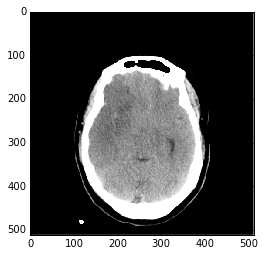

In [8]:
rootDir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\'
datasetDir = 'MRCLEAN_CT24h'
patient = '\\0004\\CT24h\\thick\\pat0004_resampled.mhd'

path = rootDir + datasetDir + patient

# --- Read Image ---
img = sitk.ReadImage(path)

# --- Load Data ---

center = 30
width = 80

window_filter = sitk.IntensityWindowingImageFilter()
window_filter.SetWindowMinimum(center - (width / 2))
window_filter.SetWindowMaximum(center + (width / 2))
window_filter.SetOutputMinimum(0)
window_filter.SetOutputMaximum(255)

img_data = sitk.GetArrayFromImage(img)

img_plot = sitk.GetArrayFromImage(window_filter.Execute(img))
plt.imshow(img_plot[13,:,:], cmap='gray', interpolation='none')

# Testing SkullStripping with 2D connected-component analysis ##

In [9]:
import skullStripping2D as ss

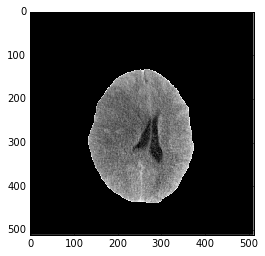

In [10]:
stripped = ss.skullstripping(img_data[5:27])

plt.imshow(stripped[13,:,:], cmap='gray', interpolation='none')

In [15]:
# --- Save image ---
img_new = sitk.GetImageFromArray(stripped.astype(int))
patient = '\\0004\\CT24h\\thick\\ct24h_skullstripped.mhd'

path = rootDir + datasetDir + patient

sitk.WriteImage(img_new, path)

# Testing utils.py reading datasets and retrieving random batches

In [1]:
from __future__ import division

import os
import numpy as np
import openpyxl as ox
import operator

def dense_to_one_hot(labels_dense, num_classes):
    """
    Convert class labels from scalars to one-hot vectors.
    Args:
    labels_dense: Dense labels.
    num_classes: Number of classes.

    Outputs:
    labels_one_hot: One-hot encoding for labels.
    """

    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot

def read_dataset(image_dir, label_filename, validation_ratio=0.25, test_ratio=0.15, dense_labels=False, augmented=True):
    """
    Function to read up images and labels.
    Store only paths as images would fit to memory.

    MRS@90 hardcoded as label attribute in label_filename -> column 'AE'
    """

    followid_attribute = 'AB2:AB501'
    label_attribute = 'AE2:AE501'

    # --- Retrieve all patients we have images from ---
    patients = [name for name in os.listdir(image_dir) if name.split('.', 1)[1]=="mhd"]

    all_samples = len(patients)

    # --- Load labels from file ---
    labels_wb = ox.load_workbook(label_filename)
    labels_ws = labels_wb.active

    label_dict = {key[0].value.zfill(4): value[0].value 
        for (key, value) in zip(labels_ws[followid_attribute], labels_ws[label_attribute]) }

    # --- Store images(optionally more per patient) + labels ---
    all_images = [ image_dir + '\\' + name for name in patients ]
    all_labels = [ label_dict[name.split('.',1)[0].split('_')[0]] for name in patients ]				

    all_labels = np.array( all_labels )
    all_images = np.array( all_images )

    uni, classes = np.unique(all_labels, return_counts = True)
    num_classes = np.shape(classes)[0]

    num_examples = np.min(classes) * num_classes
    smallest_class = dict(zip(classes, uni))[np.min(classes)]

    indices = []
    for i in range(num_classes):
        indices_class_i = np.where(all_labels == i)[0]
        if i != smallest_class:
            perm = np.arange(min(classes))
            np.random.shuffle(perm)
            indices_class_i = indices_class_i[perm]

        indices = np.append(indices, indices_class_i)

    indices = [int(x) for x in indices]

    all_labels = all_labels[indices]
    all_images = all_images[indices]


    # Select original images for validation/test and augmented for training
    if augmented:
        original = np.array([image.split("_o")[0].split("\\")[-1] for image in all_images \
                     if "_o" in image.split("\\")[-1] and not "_2" in image.split("\\")[-1]])
    else:
        original = np.array([image.split("\\")[-1].split('.')[0] for image in all_images \
                     if not "_2" in image.split("\\")[-1]])
    perm = np.arange(np.shape(original)[0])
    np.random.shuffle(perm)
    original = original[perm]

    # Calculate and cut the subsets
    validation_size = int(np.shape(original)[0]*validation_ratio)
    test_size = int(np.shape(original)[0]*test_ratio)

    # ONLY IN CASE OF CLASSES = 2
    validation_patIDs = []
    i = 0
    while len(validation_patIDs) < validation_size:
        pat = original[i]
        if len(validation_patIDs) < validation_size/2 and label_dict[pat] == 0:
            validation_patIDs.append(pat)
        if len(validation_patIDs) >= validation_size/2 and label_dict[pat] == 1:
            validation_patIDs.append(pat)
        i += 1

    test_patIDs = []
    i=0
    while len(test_patIDs) < test_size:
        pat = original[i]
        if not pat in validation_patIDs:
            if len(test_patIDs) < test_size/2 and label_dict[pat] == 0:
                test_patIDs.append(pat)
            if len(test_patIDs) >= test_size/2 and label_dict[pat] == 1:
                test_patIDs.append(pat)
        i += 1

    training_patIDs = [pat for pat in original if not pat in validation_patIDs and not pat in test_patIDs]

    training_images = []
    training_labels = []
    validation_images = []
    validation_labels = []	
    test_images = []
    test_labels = []

    if augmented:
        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0].split('_')[0]
            if pat in training_patIDs:
                training_images.append(image)
                training_labels.append(label_dict[pat])	 

        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0]
            if "_o" in pat and not "_2" in pat and pat.split('_')[0] in validation_patIDs:
                validation_images.append(image)
                validation_labels.append(label_dict[pat.split('_')[0]])

        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0]
            if "_o" in pat and not "_2" in pat and pat.split('_')[0] in test_patIDs:
                test_images.append(image)
                test_labels.append(label_dict[pat.split('_')[0]])
    else:

        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0].split('_')[0]
            if pat in training_patIDs:
                training_images.append(image)
                training_labels.append(label_dict[pat])

        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0]
            if not "_2" in pat and pat.split('_')[0] in validation_patIDs:
                validation_images.append(image)
                validation_labels.append(label_dict[pat.split('_')[0]])

        for image in all_images:
            pat = image.split("\\")[-1].split('.')[0]
            if not "_2" in pat and pat.split('_')[0] in test_patIDs:
                test_images.append(image)
                test_labels.append(label_dict[pat.split('_')[0]])

    # Shuffling
    perm = np.arange(len(training_images))
    np.random.shuffle(perm)
    training_images = np.array(training_images)[perm]
    training_labels = np.array(training_labels)[perm]

    perm = np.arange(len(validation_images))
    np.random.shuffle(perm)
    validation_images = np.array(validation_images)[perm]
    validation_labels = np.array(validation_labels)[perm]

    perm = np.arange(len(test_images))
    np.random.shuffle(perm)
    test_images = np.array(test_images)[perm]
    test_labels = np.array(test_labels)[perm]

    if not dense_labels:
        training_labels = dense_to_one_hot(training_labels, num_classes)
        validation_labels = dense_to_one_hot(validation_labels, num_classes)
        test_labels = dense_to_one_hot(test_labels, num_classes)

    # --- Return DataSet objects ---	
    return DataSet(training_images, training_labels, validation_images, validation_labels, test_images, test_labels)

class DataSet(object):

    def __init__(self, training_images, training_labels, validation_images, validation_labels, test_images, test_labels):

        self._Training = SubSet(training_images, training_labels)
        self._Validation = SubSet(validation_images, validation_labels)
        self.Test = SubSet(test_images, test_labels)

    @property
    def epochs_completed(self):
        return self._epochs_completed

    @property
    def Training(self):
        return self._Training

    @property
    def Validation(self):
        return self._Validation

class SubSet(object):
    """
    Utility class to handle training and validation set structure.
    """
    def __init__(self, images, labels):
        """
        Builds dataset with images and labels.
        Args:
            images: Images data.
            labels: Labels data
        """
        assert images.shape[0] == labels.shape[0], (
            "images.shape: {0}, labels.shape: {1}".format(str(images.shape), str(labels.shape)))

        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def index_in_epoch(self):
        return self._index_in_epoch


    def next_batch(self, batch_size, multiAttenuation = False):
        """
        Return the next `batch_size` examples from this data set.
        Args:
                        batch_size: Batch size.
        """
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch >= self._num_examples:
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples

        end = self._index_in_epoch

        image_batch = np.array([ image_path.split("\\")[-1] for image_path in self._images[start:end]])
        label_batch = self._labels[start:end]

        if not multiAttenuation:
            #image_batch = np.swapaxes(image_batch, 1, 2)
            #image_batch = np.swapaxes(image_batch, 2, 3)
            a = 0
            
            # --- Only in case of 3D model ---
            # image_batch = np.expand_dims(image_batch, axis=4)

        else:
            image_batch = np.swapaxes(image_batch, 1, 2)
            image_batch = np.swapaxes(image_batch, 2, 3)
            image_batch = np.swapaxes(image_batch, 3, 4)

            image_batch = np.swapaxes(image_batch, 1, 2)
            image_batch = np.swapaxes(image_batch, 2, 3)

        return image_batch, label_batch


    def getImageArray(self, image_path, multiAttenuation):
        """
        Returns 
        Args:
            image_path: Path of image to read from.
            multiAttenuation: Boolean whether ranges of attenuation is required
        """

        if not multiAttenuation:
            return sitk.GetArrayFromImage(sitk.ReadImage(image_path))[9:25,:,:]
        else:
            arr = sitk.GetArrayFromImage(sitk.ReadImage(image_path))[9:25,:,:]
            return np.array([
                np.multiply(np.divide(np.add(arr, 50),130),255),
                np.multiply(np.divide(arr, 80),255),
                np.multiply(np.divide(arr, 130),255)
            ])

In [54]:
root = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\CT24h_Datasets\\'
dataset_name = 'Normalized_RigidAligned_128x128x30+Flipped_augmented3'
image_dir = root + dataset_name

label_filename = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\MRCLEAN\\MRCLEAN_MRSDICH.xlsx'

dataset = read_dataset(image_dir, label_filename)

In [78]:
images, labels = dataset.Training.next_batch(10)
# images = dataset.Training.images

print(images[0:10,])

['0141_2.mhd' '0367_1.mhd' '0138_2.mhd' '0008_1.mhd' '0091_o.mhd'
 '0380_o.mhd' '0130_o.mhd' '0060_3.mhd' '0188_3.mhd' '0171_2.mhd']


# Operations run through all data #

## Skull stripping original images

In [1]:
"""
Computes the skull stripping of all the original data in the dataset.
Original images are already resampled to 30 slices in depth.
"""

import skullStripping2D as ss
import os
import SimpleITK as sitk
import numpy as np

data_dir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\CT24h_Datasets\\RigidAligned_256x256x30\\'
new_data_dir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\CT24h_Datasets\\RigidAligned_Skullstripped_256x256x30\\'
#images_root_sub = 'MRCLEAN_CT24h\\'
#image_sub = '\CT24h\\thick\\'

# --- Retrieve all patients we have images from ---
patients = [name.zfill(4) for name in os.listdir('D:\\AdamHilbert\\DNN_Classification_Project\\data\\MRCLEAN_CT24h\\')
                                    if os.path.isdir(
                            os.path.join('D:\\AdamHilbert\\DNN_Classification_Project\\data\\MRCLEAN_CT24h\\', name))]

for patient in patients: 
    filename = patient.zfill(4) + '.mhd'
    fullpath = data_dir + filename

    if(not os.path.isfile( new_data_dir + filename )):    
        # --- Read Image ---
        image = sitk.ReadImage(fullpath)

        # --- Load Data ---
        img_data = sitk.GetArrayFromImage(image)

        # --- Skullstripping ---
        data_new = ss.skullstripping(img_data)

        # --- Save image ---
        img_new = sitk.GetImageFromArray(data_new.astype(int))
        img_new.SetSpacing(image.GetSpacing())

        sitk.WriteImage(img_new, new_data_dir + filename)

    print(patient + ' done.')

0001 done.


skullStripping2D.py:100: RuntimeWarning: invalid value encountered in true_divide
  mean_int.append(np.true_divide(img_compi.sum(),(img_compi!=0).sum()))


0002 done.
0004 done.
0005 done.
0006 done.
0008 done.
0010 done.
0011 done.
0012 done.
0013 done.
0014 done.
0015 done.
0016 done.
0017 done.
0018 done.
0019 done.
0021 done.
0023 done.
0024 done.
0025 done.
0026 done.
0028 done.
0029 done.
0030 done.
0031 done.
0032 done.
0033 done.
0034 done.
0037 done.
0039 done.
0043 done.
0044 done.
0045 done.
0046 done.
0048 done.
0049 done.
0050 done.
0051 done.
0052 done.
0053 done.
0054 done.
0056 done.
0058 done.
0059 done.
0060 done.
0061 done.
0063 done.
0065 done.
0067 done.
0068 done.
0069 done.
0071 done.
0072 done.
0074 done.
0076 done.
0078 done.
0080 done.
0081 done.
0085 done.
0087 done.
0091 done.
0092 done.
0093 done.
0095 done.
0096 done.
0097 done.
0099 done.
0100 done.
0102 done.
0104 done.
0105 done.
0106 done.
0111 done.
0112 done.
0114 done.
0115 done.
0118 done.
0119 done.
0120 done.
0122 done.
0123 done.
0124 done.
0125 done.
0127 done.
0128 done.
0129 done.
0130 done.
0132 done.
0133 done.
0134 done.
0135 done.
0136 done.

RuntimeError: Exception thrown in SimpleITK ReadImage: ..\..\..\..\..\SimpleITK\Code\IO\src\sitkImageReaderBase.cxx:71:
sitk::ERROR: The file "D:\AdamHilbert\DNN_Classification_Project\data\CT24h_Datasets\RigidAligned_256x256x30\RigidAligned.mhd" does not exist.

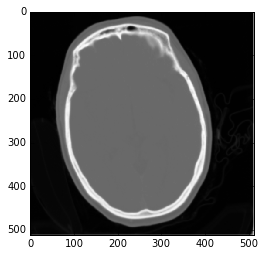

In [10]:
plt.imshow(img_data[13,:,:], cmap='gray', interpolation='none')

## Skull stripping registered images

In [12]:
import skullStripping2D as ss
import os
import SimpleITK as sitk
import numpy as np

data_dir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\'
images_root_sub = 'MRCLEAN_CT24h\\'
image_sub = '\CT24h\\thick\\alignedRigid\\'

# --- Retrieve all patients we have images from ---
patients = [name.zfill(4) for name in os.listdir(data_dir + images_root_sub)
                if os.path.isdir(os.path.join(data_dir + images_root_sub, name))]

#for patient in patients:
patient = patients[0]
# == Original ==
filename = 'result.mhd'
fullpath = data_dir + images_root_sub + patient + image_sub + filename

# --- Read Image ---
image = sitk.ReadImage(fullpath)

# --- Load Data ---
img_data = sitk.GetArrayFromImage(image)

# --- Skullstripping ---
data_new = ss.skullstripping(img_data)

# --- Save image ---
img_new = sitk.GetImageFromArray(data_new)
newFileName = 'ct24h_registered_skullstripped.mhd'

sitk.WriteImage(img_new, data_dir + images_root_sub + patient + image_sub + newFileName)

# == Mirrored ==
filename = 'result2.mhd'
fullpath = data_dir + images_root_sub + patient + image_sub + filename

# --- Read Image ---
image = sitk.ReadImage(fullpath)

# --- Load Data ---
img_data = sitk.GetArrayFromImage(image)

# --- Skullstripping ---
data_new = ss.skullstripping(img_data)

# --- Save image ---
img_new = sitk.GetImageFromArray(data_new)
newFileName = 'ct24h_registered_skullstripped_2.mhd'

sitk.WriteImage(img_new, data_dir + images_root_sub + patient + image_sub + newFileName)

    

skullStripping2D.py:99: RuntimeWarning: invalid value encountered in true_divide
  mean_int.append(np.true_divide(img_compi.sum(),(img_compi!=0).sum()))


# RFNN utils testing

## 2D basis functions

In [257]:
import numpy as np
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
%pylab inline

def floatX(X):
    return np.asarray(X, dtype=tf.float32)

def init_basis_hermite(sigma,bases):
    filterExtent = 3*sigma
    x = np.arange(-filterExtent, filterExtent+1, dtype=np.float)
    imSize = filterExtent*2+1
    impulse = np.zeros( (np.int(imSize), np.int(imSize)) )
    impulse[(np.int(imSize))/2,(np.int(imSize))/2] = 1.0
    nrBasis = 15
    hermiteBasis = np.empty( (np.int(nrBasis), np.int(imSize), np.int(imSize)) )
    g = 1.0/(np.sqrt(2*np.pi)*sigma)*np.exp(np.square(x)/(-2*np.square(sigma)))
    g = g/g.sum()
    g1 = sigma * -(x/ np.square(sigma)) * g
    g2 = np.square(sigma) * ( (np.square(x)-np.power(sigma,2)) / np.power(sigma,4)) * g
    g3 = np.power(sigma,3) * -( (np.power(x,3) - 3 * x * np.square(sigma)) / np.power(sigma,6)) * g
    g4 = np.power(sigma,4) * ( ( (np.power(x,4) - 6 *  np.square(x) * np.square(sigma) + 3 * np.power(sigma,4)) / np.power(sigma,8) ) ) * g
    gauss0x = filters.convolve1d(impulse, g, axis=1)
    gauss0y = filters.convolve1d(impulse, g, axis=0)
    gauss1x = filters.convolve1d(impulse, g1, axis=1)
    gauss1y = filters.convolve1d(impulse, g1, axis=0)
    gauss2x = filters.convolve1d(impulse, g2, axis=1)
    gauss0 = filters.convolve1d(gauss0x, g, axis=0)
    hermiteBasis[0,:,:] = gauss0                                  # g
    hermiteBasis[1,:,:] = filters.convolve1d(gauss0y, g1, axis=1) # g_x
    hermiteBasis[2,:,:] = filters.convolve1d(gauss0x, g1, axis=0) # g_y
    hermiteBasis[3,:,:] = filters.convolve1d(gauss0y, g2, axis=1) # g_xx
    hermiteBasis[4,:,:] = filters.convolve1d(gauss0x, g2, axis=0) # g_yy
    hermiteBasis[5,:,:] = filters.convolve1d(gauss1x, g1, axis=0) # g_xy
    hermiteBasis[6,:,:] = filters.convolve1d(gauss0y, g3, axis=1) # g_xxx
    hermiteBasis[7,:,:] = filters.convolve1d(gauss0x, g3, axis=0) # g_yyy
    hermiteBasis[8,:,:] = filters.convolve1d(gauss1y, g2, axis=1) # g_xxy
    hermiteBasis[9,:,:] = filters.convolve1d(gauss1x, g2, axis=0) # g_yyx
    hermiteBasis[10,:,:] = filters.convolve1d(gauss0y, g4, axis=1) # g_xxxx
    hermiteBasis[11,:,:] = filters.convolve1d(gauss0x, g4, axis=0) # g_yyyy
    hermiteBasis[12,:,:] = filters.convolve1d(gauss1y, g3, axis=1) # g_xxxy
    hermiteBasis[13,:,:] = filters.convolve1d(gauss1x, g3, axis=0) # g_yyyx
    hermiteBasis[14,:,:] = filters.convolve1d(gauss2x, g2, axis=0) # g_yyxx
    
    return hermiteBasis[0:bases,:,:]




Populating the interactive namespace from numpy and matplotlib


C:\Users\Adam Hilbert\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


C:\Users\Adam Hilbert\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(10, 10, 10)


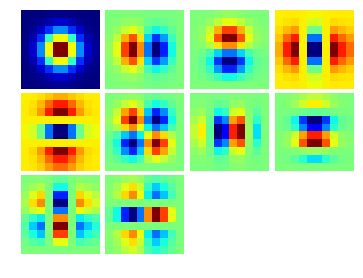

In [258]:
nrBasis = 10
bases = init_basis_hermite(1.5, nrBasis)
print(np.shape(bases))
f = plt.figure()
f.set_figheight(6)
f.set_figwidth(6)
f.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(1,nrBasis+1):
    ax = f.add_subplot(4,4,i)
    ax.imshow(bases[i-1,:,:], cmap='jet')
    ax.set_axis_off()
    


In [259]:
alphas = np.random.uniform(-1.0, 1.0, (64, 1, nrBasis))
alphas = np.transpose(alphas[:,:,:,None,None])
hermit = np.transpose(bases[None,None,:,:,:])
print(np.shape(alphas))
print(np.shape(hermit))

kernels = alphas * hermit
print(np.shape(kernels))
kernels = np.sum(kernels, axis=2)
print(np.shape(kernels))

(1, 1, 10, 1, 64)
(10, 10, 10, 1, 1)
(10, 10, 10, 1, 64)
(10, 10, 1, 64)


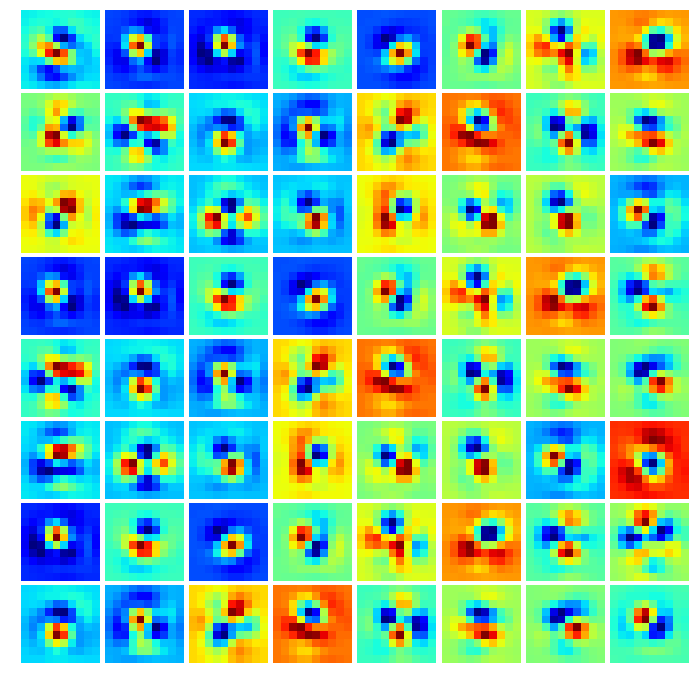

In [260]:
f, axarr = plt.subplots(8, 8)
f.set_figheight(12)
f.set_figwidth(12)
f.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(8):
    for j in range(8):
        axarr[j, i].imshow(kernels[:,:,0,i*3+j], cmap='jet')
        axarr[j, i].set_axis_off()

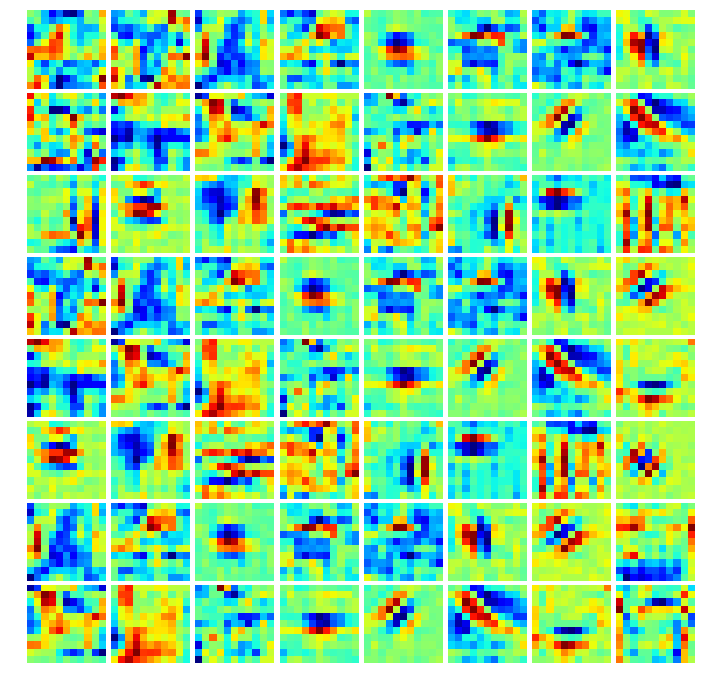

In [250]:
f, axarr = plt.subplots(8, 8)
f.set_figheight(12)
f.set_figwidth(12)
f.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(8):
    for j in range(8):
        axarr[j, i].imshow(kernels_final[i*3+j], cmap='jet')
        axarr[j, i].set_axis_off()

# SVM test

In [19]:
from __future__ import division
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
import sklearn.svm as svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# --------- Load data ----------
n_classes = 2

root = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\CT24h_Datasets\\'
image_dir = root + 'Normalized_Skullstripped_128x128x22+Flipped'
label_filename = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\MRCLEAN\\MRCLEAN_MRSDICH.xlsx'

dataset = read_dataset(image_dir, label_filename)

fpr = np.zeros((200))
tpr = np.zeros((200))
tr = np.linspace(0,1,200)
acc = 0
iters = 20

for k in range(iters):
    X_train, labels_train = dataset.Training.next_batch(dataset.Training.num_examples)
    X_test, labels_test = dataset.Validation.next_batch(dataset.Validation.num_examples)

    X_train = X_train.reshape(dataset.Training.num_examples, -1)
    X_test = X_test.reshape(dataset.Validation.num_examples, -1)

    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=np.random.RandomState(0))).fit(X_train, labels_train)
    Y = classifier.predict(X_test)
    y_score = classifier.predict_proba(X_test)

#    for i in range(n_classes):
#        yi = Y[np.where(labels_test==i)[0]]
#        acc = np.sum(yi==i)/np.sum(labels_test==i)
#        print('Accuracy on class \'%s\': %s' %(i,acc))

    acc += np.sum(Y==labels_test)/Y.shape[0] / iters

    # Compute ROC curve and ROC area for each class

    for j in range(200):
        tp = 0
        fp = 0
        for i in range(np.shape(y_score)[0]):
            if y_score[i][0] >= tr[j]:
                if labels_test[i][0] == 1:
                    tp += 1
                else:
                    fp += 1
        tpr[j] += tp/np.sum(labels_test[:,0]==1) /iters
        fpr[j] += fp/np.sum(labels_test[:,1]==1) /iters

roc_auc = auc(fpr, tpr)

print('Multi-class Accuracy: %s' %acc)

NameError: name 'read_dataset' is not defined

Multi-class Accuracy and AUC for  : 1.27011494253, 0.660270091354


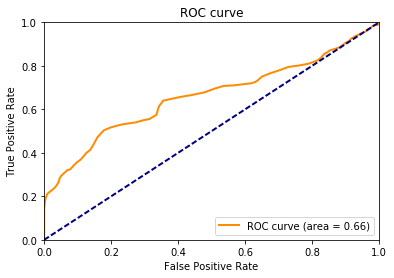

In [77]:
print('Multi-class Accuracy and AUC for ' + ' : %s, %s' %(acc,roc_auc))
np.save('./Statistics/tpr_Norm_Skullstripped_Flipped.npy', tpr)
np.save('./Statistics/fpr_Norm_Skullstripped_Flipped.npy', fpr)
    
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# ROC

In [7]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls


def roc_curve(fpr, tpr, index1, y1, fpr2, tpr2, index2, y2):
    trace11= Scatter(
        x = fpr,
        y = tpr,
        line = dict(
            color = 'red',
            width = 2 ),
        name = '2D (AUC = %0.2f)' % (auc)
    )
    trace12= Scatter(
        x = fpr[index1],
        y = tpr[index1],
        line = dict(
            color = 'red'),
        mode = 'markers',
        showlegend = False
    )
    trace21= Scatter(
        x = fpr2,
        y = tpr2,
        line = dict(
            color = 'green',
            width = 2 ),
        name = '3D (AUC = %0.2f)' % (auc2)
    )
    trace22= Scatter(
        x = fpr2[index2],
        y = tpr2[index2],
        line = dict(
            color = 'green'),
        mode = 'markers',
        showlegend = False
    )
    trace3= Scatter(
        x = [0,1],
        y = [0,1],
        name = 'Random',
        mode = 'lines',
        line = dict(
            color = 'navy',
            dash = 'dash',
            width = 1 ),
        showlegend = False
    )

    layout1 = dict(
                    autosize=False,
                    width=600,
                    height=600,
                    xaxis = dict(title = 'False Positive Rate (FPR)'),
                    yaxis = dict(title = 'True Positive Rate (TPR)'),
                    legend = dict(
                        orientation="h",
                        xanchor = "center",
                        x=0.5,
                        y=1.2),
                    annotations=[
                        dict(
                            x=fpr[index1],
                            y=tpr[index1],
                            xref='x',
                            yref='y',
                            text='J=%0.2f' %y1,
                            showarrow=True,
                            borderwidth=1,
                            arrowhead=0,
                            arrowsize=1,
                            bordercolor= 'red',
                            arrowcolor = 'red',
                            ax=0,
                            ay=-20,
                            bgcolor='lightgray'
                        ),
                        dict(
                            x=fpr2[index2],
                            y=tpr2[index2],
                            xref='x',
                            yref='y',
                            text='J=%0.2f' %y2,
                            showarrow=True,
                            borderwidth=1,
                            arrowhead=0,
                            arrowsize=1,
                            bordercolor= 'green',
                            arrowcolor = 'green',
                            ax=0,
                            ay=-20,
                            bgcolor='lightgray'
                        )
                    ]
                  )

    data1 = Data([trace11, trace12, trace21, trace22, trace3])
    fig = dict(data=data1, layout=layout1)

    return fig

In [8]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

py.sign_in('hilbysfe', '9FK3uiXFdhGzfJQzkcsK')

# -------------------- ORIGINAL DATASET -------------------
tpr = np.load('./Statistics/CTNET/2Dfinal/Normalized_Resampled_128x128x30/tpr.npy')
fpr = np.load('./Statistics/CTNET/2Dfinal/Normalized_Resampled_128x128x30/fpr.npy')
auc = np.load('./Statistics/CTNET/2Dfinal/Normalized_Resampled_128x128x30/auc.npy')
            
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i
        
tpr2 = np.load('./Statistics/CTNET/3Dfinal/Normalized_Resampled_128x128x30/tpr.npy')
fpr2 = np.load('./Statistics/CTNET/3Dfinal/Normalized_Resampled_128x128x30/fpr.npy')
auc2 = np.load('./Statistics/CTNET/3Dfinal/Normalized_Resampled_128x128x30/auc.npy')
        
y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
fig = roc_curve(fpr, tpr, index1, y1, fpr2, tpr2, index2, y2)
    
py.iplot(fig)


In [4]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

py.sign_in('hilbysfe', '9FK3uiXFdhGzfJQzkcsK')

# -------------------- AUGMENTED3 DATASET -------------------
tpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_tpr.npy')
fpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_fpr.npy')
auc = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_auc.npy')
            
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i
        
tpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_tpr.npy')
fpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_fpr.npy')
auc2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_auc.npy')
               
y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
tpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_tpr.npy')
fpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_fpr.npy')
auc3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_auc.npy')
        
y3 = 0
index3 = 0
for i in range(len(tpr3)):
    if tpr3[i]+(1-fpr3[i])-1 > y3:
        y3=tpr3[i]+(1-fpr3[i])-1
        index3 = i
        
fig = roc_curve(fpr, tpr, index1, y1, fpr2, tpr2, index2, y2, fpr3, tpr3, index3, y3)
    
py.iplot(fig)

In [80]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

py.sign_in('hilbysfe', '9FK3uiXFdhGzfJQzkcsK')

# -------------------- AUGMENTED5 DATASET -------------------
tpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_tpr.npy')
fpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_fpr.npy')
auc = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_auc.npy')
            
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i
        
tpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_tpr.npy')
fpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_fpr.npy')
auc2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_auc.npy')
               
y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
tpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_tpr.npy')
fpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_fpr.npy')
auc3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_auc.npy')
        
y3 = 0
index3 = 0
for i in range(len(tpr3)):
    if tpr3[i]+(1-fpr3[i])-1 > y3:
        y3=tpr3[i]+(1-fpr3[i])-1
        index3 = i
        
fig = roc_curve(fpr, tpr, index1, y1, fpr2, tpr2, index2, y2, fpr3, tpr3, index3, y3)
    
py.iplot(fig)

In [25]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

py.sign_in('hilbysfe', 'ZdgANoYXAnH015PM4hIV')

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(18)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

lw = 2

# Original dataset

tpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_linear_tpr.npy')
fpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_linear_fpr.npy')
auc = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_linear_auc.npy')
                            
tpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_linear_tpr.npy')
fpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_linear_fpr.npy')
auc2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_linear_auc.npy')
               
tpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_linear_tpr.npy')
fpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_linear_fpr.npy')
auc3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_linear_auc.npy')


# Youden index
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i

y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
y3 = 0
index3 = 0
for i in range(len(tpr3)):
    if tpr3[i]+(1-fpr3[i])-1 > y3:
        y3=tpr3[i]+(1-fpr3[i])-1
        index3 = i

        
ax1.set_title('Original dataset')

ax1.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Original (AUC = %0.2f, Youden = %0.2f)' % (auc, y1))
ax1.plot(fpr[index1], tpr[index1], 'o', color='darkorange')

ax1.plot(fpr2, tpr2, color='darkred',
         lw=lw, label='Aligned (AUC = %0.2f, Youden = %0.2f)' % (auc2, y2))
ax1.plot(fpr2[index2], tpr2[index2], 'o', color='darkred')

ax1.plot(fpr3, tpr3, color='darkgreen',
         lw=lw, label='Skullstripped (AUC = %0.2f, Youden = %0.2f)' % (auc3, y3))
ax1.plot(fpr3[index3], tpr3[index3], 'o', color='darkgreen')

ax1.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')


# Augmented-3

tpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_tpr.npy')
fpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_fpr.npy')
auc = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented3_linear_auc.npy')
                            
tpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_tpr.npy')
fpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_fpr.npy')
auc2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented3_linear_auc.npy')
               
tpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_tpr.npy')
fpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_fpr.npy')
auc3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented3_linear_auc.npy')

# Youden index
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i

y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
y3 = 0
index3 = 0
for i in range(len(tpr3)):
    if tpr3[i]+(1-fpr3[i])-1 > y3:
        y3=tpr3[i]+(1-fpr3[i])-1
        index3 = i


ax2.set_title('Augmented-3')        
        
ax2.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Original (AUC = %0.2f, Youden = %0.2f)' % (auc, y1))
ax2.plot(fpr[index1], tpr[index1], 'o', color='darkorange')

ax2.plot(fpr2, tpr2, color='darkred',
         lw=lw, label='Aligned (AUC = %0.2f, Youden = %0.2f)' % (auc2, y2))
ax2.plot(fpr2[index2], tpr2[index2], 'o', color='darkred')

ax2.plot(fpr3, tpr3, color='darkgreen',
         lw=lw, label='Skullstripped (AUC = %0.2f, Youden = %0.2f)' % (auc3, y3))
ax2.plot(fpr3[index3], tpr3[index3], 'o', color='darkgreen')

ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

# Augmented-5

tpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_tpr.npy')
fpr = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_fpr.npy')
auc = np.load('./Statistics/SVM/Normalized_Resampled_128x128x30_augmented5_linear_auc.npy')
                            
tpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_tpr.npy')
fpr2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_fpr.npy')
auc2 = np.load('./Statistics/SVM/Normalized_RigidAligned_128x128x30_augmented5_linear_auc.npy')
               
tpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_tpr.npy')
fpr3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_fpr.npy')
auc3 = np.load('./Statistics/SVM/Normalized_Skullstripped_128x128x22_augmented5_linear_auc.npy')

# Youden index
y1 = 0
index1 = 0
for i in range(len(tpr)):
    if tpr[i]+(1-fpr[i])-1 > y1:
        y1=tpr[i]+(1-fpr[i])-1
        index1 = i

y2 = 0
index2 = 0
for i in range(len(tpr2)):
    if tpr2[i]+(1-fpr2[i])-1 > y2:
        y2=tpr2[i]+(1-fpr2[i])-1
        index2 = i
        
y3 = 0
index3 = 0
for i in range(len(tpr3)):
    if tpr3[i]+(1-fpr3[i])-1 > y3:
        y3=tpr3[i]+(1-fpr3[i])-1
        index3 = i

ax3.set_title('Augmented-5')  

ax3.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Original (AUC = %0.2f, Youden = %0.2f)' % (auc, y1))
ax3.plot(fpr[index1], tpr[index1], 'o', color='darkorange')

ax3.plot(fpr2, tpr2, color='darkred',
         lw=lw, label='Aligned (AUC = %0.2f, Youden = %0.2f)' % (auc2, y2))
ax3.plot(fpr2[index2], tpr2[index2], 'o', color='darkred')

ax3.plot(fpr3, tpr3, color='darkgreen',
         lw=lw, label='Skullstripped (AUC = %0.2f, Youden = %0.2f)' % (auc3, y3))
ax3.plot(fpr3[index3], tpr3[index3], 'o', color='darkgreen')

ax3.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')


plotly_fig = tls.mpl_to_plotly(fig)
plotly_fig['layout']['showlegend'] = True
py.iplot(plotly_fig, update=update)

#unique_url = py.plot_mpl(fig, filename="SVM ROC")


# Normalizing images

In [1]:
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
%pylab inline

ModuleNotFoundError: No module named 'SimpleITK'

In [19]:
root = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\CT24h_Datasets\\'
image_dir = root + 'Resampled_256x256x30\\'

filenames = [filename for filename in os.listdir(image_dir) if filename.endswith(".mhd")]
files = [sitk.ReadImage(image_dir + filename) for filename in filenames]
images = np.array([sitk.GetArrayFromImage(file) for file in files])
        
print(np.shape(images))

(712L, 22L, 128L, 128L)


In [20]:
mean_image = np.mean(images, axis=0)
print(np.shape(mean_image))
std_image = np.std(images, axis=0)
print(np.shape(std_image))

(22L, 128L, 128L)
(22L, 128L, 128L)


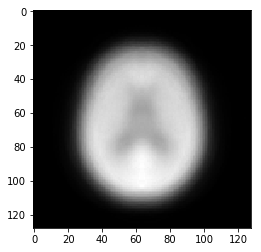

In [21]:
img = sitk.GetImageFromArray(mean_image)

center = 30
width = 80

window_filter = sitk.IntensityWindowingImageFilter()
window_filter.SetWindowMinimum(center - (width / 2))
window_filter.SetWindowMaximum(center + (width / 2))
window_filter.SetOutputMinimum(0)
window_filter.SetOutputMaximum(255)

img_data = sitk.GetArrayFromImage(img)
img_plot = sitk.GetArrayFromImage(window_filter.Execute(img))

plt.imshow(img_plot[11,:,:], cmap='gray', interpolation='none')

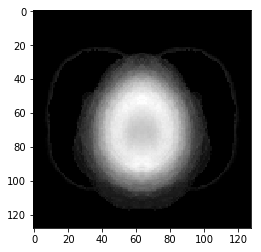

In [22]:
img = sitk.GetImageFromArray(std_image)

center = 30
width = 80

window_filter = sitk.IntensityWindowingImageFilter()
window_filter.SetWindowMinimum(center - (width / 2))
window_filter.SetWindowMaximum(center + (width / 2))
window_filter.SetOutputMinimum(0)
window_filter.SetOutputMaximum(255)

img_data = sitk.GetArrayFromImage(img)
img_plot = sitk.GetArrayFromImage(window_filter.Execute(img))

plt.imshow(img_plot[20,:,:], cmap='gray', interpolation='none')



In [23]:
def div0( a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

centered_images = np.array(
                        [images[i,:,:,:] - mean_image for i in range(np.shape(images)[0])])
normalized_images = np.array(
                        [div0(centered_images[i,:,:,:], std_image) for i in range(np.shape(images)[0])])

In [24]:
# --- Save image ---
new_image_dir = root + 'Normalized_Skullstripped_128x128x22+Flipped\\'
os.mkdir(new_image_dir)
for i, new_data in enumerate(normalized_images):
    img_new = sitk.GetImageFromArray(new_data)
    img_new.SetSpacing(files[i].GetSpacing())
    filename = filenames[i]

    sitk.WriteImage(img_new, new_image_dir + filename)

# MIPs

In [ ]:
import os

with open(old_files) as fo:
    old_filenames = fo.readlines()
old_filenames = [x.strip("\n") for x in old_filenames]

with open(new_files) as fn:
    new_filenames = fn.readlines()
new_filenames = [x.strip("\n") for x in new_filenames]

for i in range(len(new_filenames)):
    command = "dcmdjpeg " + old_filenames[i] + " " + new_filenames[i]);
    os.system(command)

# Show filters

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%pylab inline

kernels_0 = np.load('./Kernels/kernel_0.npy')
alphas_0 = np.load('./Kernels/alphas_0.npy')

kernels_final = np.load('./Kernels/kernel_final.npy')
alphas_final = np.load('./Kernels/alphas_final.npy')

# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(kernels_0[0], cmap='jet')
# axarr[1].imshow(kernels_final[0], cmap='jet')


Populating the interactive namespace from numpy and matplotlib


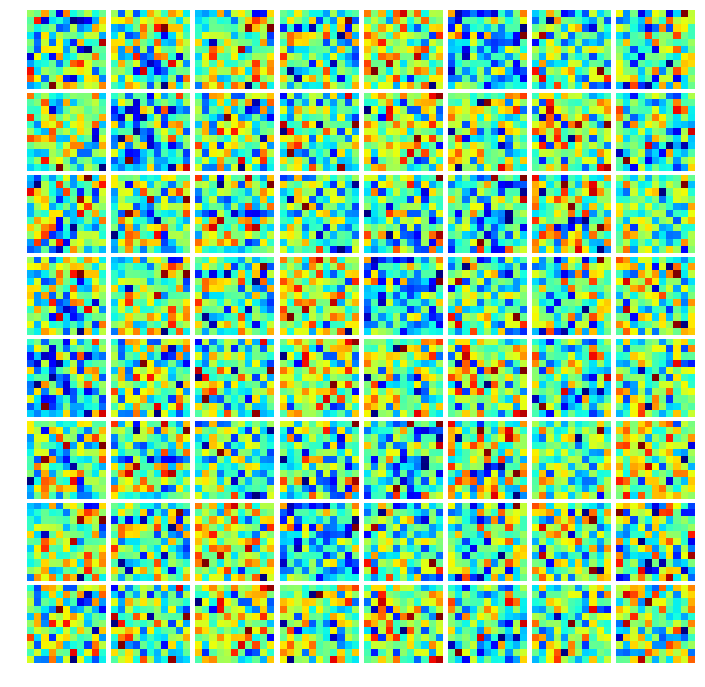

In [248]:
f, axarr = plt.subplots(8, 8)
f.set_figheight(12)
f.set_figwidth(12)
f.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(8):
    for j in range(8):
        axarr[j, i].imshow(kernels_0[i*3+j], cmap='jet')
        axarr[j, i].set_axis_off()

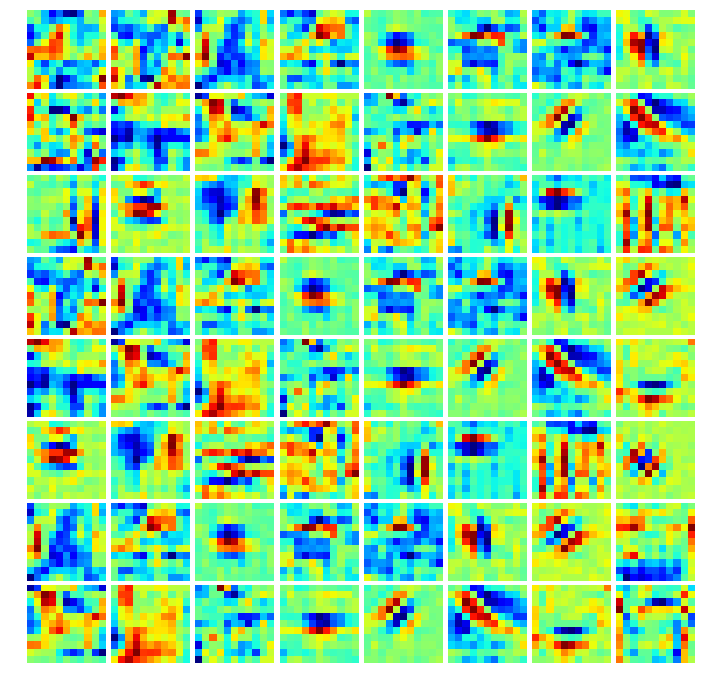

In [249]:
f, axarr = plt.subplots(8, 8)
f.set_figheight(12)
f.set_figwidth(12)
f.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(8):
    for j in range(8):
        axarr[j, i].imshow(kernels_final[i*3+j], cmap='jet')
        axarr[j, i].set_axis_off()